In [19]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from scipy import signal
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
#funcion que toma como entrada el armonico a sintonizar y las dimensiones de la imagen a espiar y devuelve un array con taps de g(t)
def g_taps(dim_vertical, dim_horizontal, armonico):

    #defino variables iniciales
    f_p = dim_vertical * dim_horizontal * 60
    f_sdr = 50e6
    harm = armonico * f_p
    
    #para el correcto funcionamiento: dependiendo del armonico, elijo cuantas muestras por pulso
    if (armonico < 5 ):
        muestras_por_pulso  = 10
    else:
        muestras_por_pulso  = 20

    samp_rate = muestras_por_pulso * f_p
    H_samples = dim_horizontal * muestras_por_pulso

    #creo el pulso
    t_continuous = np.linspace(start = 0, stop = H_samples/samp_rate, num = H_samples, endpoint= False)
    pulso = np.zeros(H_samples)
    pulso[:muestras_por_pulso] = 1

    #traslado el espectro del pulso el armonico correspondiente
    frec_armonico = np.exp(-2j*np.pi*harm*t_continuous)
    pulso_complejo = pulso*frec_armonico

    #creo el lpf del sdr
    b, a = signal.butter(6, f_sdr/2, fs=samp_rate, btype='lowpass', analog=False)

    #filtro con lpf el pulso multiplicado por armonico. El resultado es g
    g_t = signal.lfilter(b, a, pulso_complejo)
    #g_t = signal.decimate(g_t,q = muestras_por_pulso)

    # si armonico crece, necesito mas taps
    if (armonico < 5):
        g_t = g_t[:20]
    else:
        g_t = g_t[:300]

    g_t_max = np.max(np.abs(g_t))
 
    g_t = g_t / g_t_max

    return torch.tensor(g_t,dtype = torch.complex64).reshape(1,1,len(g_t))

In [13]:
def forward(img, armonico):
    filas, columnas = img.shape
    img_flatten = img.reshape(1, 1, filas * columnas)
    g_t = g_taps(filas, columnas, armonico)
    size_g_t = g_t.numel() 
    padding = (size_g_t - 10)//2   
    img_salida = nn.functional.conv1d(img_flatten, g_t, stride = 1, padding = 'same', bias = None)[0,0,:].reshape((filas,columnas))
    return img_salida

In [14]:
image_path = '../../images/VAMO!!.png'
#img = np.zeros((96,96)
img = np.asarray(Image.open(image_path))[:,:,0] #solo canal rojo
img_torch = torch.tensor(img, dtype = torch.complex64, requires_grad= True)
armonico = 3
imagen = forward(img_torch, armonico)
print(imagen)

tensor([-310.3316+162.2023j, -242.2309+110.6219j, -172.7605+63.7317j,
         ...,  284.1672-215.9980j,  294.7620-208.2000j,
         278.3180-182.8253j], grad_fn=<SliceBackward0>)


In [15]:
imagen.backward(torch.ones_like(imagen))
#imagen.backward()

In [17]:
print(img_torch.grad)
print(img_torch.grad.shape)

tensor([[ 3.6558+2.3451j,  4.0600+2.7522j,  4.2391+3.0108j,  ...,
         -0.1702+0.1468j, -0.1702+0.1468j, -0.1702+0.1468j],
        [-0.1702+0.1468j, -0.1702+0.1468j, -0.1702+0.1468j,  ...,
         -0.1702+0.1468j, -0.1702+0.1468j, -0.1702+0.1468j],
        [-0.1702+0.1468j, -0.1702+0.1468j, -0.1702+0.1468j,  ...,
         -0.1702+0.1468j, -0.1702+0.1468j, -0.1702+0.1468j],
        ...,
        [-0.1702+0.1468j, -0.1702+0.1468j, -0.1702+0.1468j,  ...,
         -0.1702+0.1468j, -0.1702+0.1468j, -0.1702+0.1468j],
        [-0.1702+0.1468j, -0.1702+0.1468j, -0.1702+0.1468j,  ...,
         -0.1702+0.1468j, -0.1702+0.1468j, -0.1702+0.1468j],
        [-0.1702+0.1468j, -0.1702+0.1468j, -0.1702+0.1468j,  ...,
         -1.7996-0.6639j, -2.5232-1.1523j, -3.2326-1.6896j]])
torch.Size([600, 800])


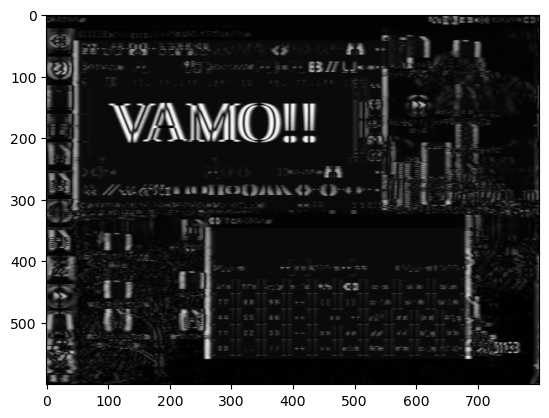

In [7]:
img_sim = np.abs(imagen.detach().numpy())

plt.figure()
plt.imshow(255*((img_sim - img_sim.min())/(img_sim.max()-img_sim.min())),cmap='gray')
plt.show()